#### Multiclass Classifier   

In binary classfier, `Weighted Sum + Sigmoid + np.round()`, WSS, gave us a value of 0 or 1.  
Run 10 WSS, one per digit. The one with the highest WSS score is the resultant class among the ten.    

![](../Figures/cnn-2.png)

In [ ]:
import numpy as np
import pandas as pd

##### one-hot encoding   
We get only one **hot** row per digit.  
Use one column per class.  
One matmul can get results for all the ten digit-classes.    
We can use dataframe get_dummies() or sklearn OneHotEncoder.   
Here is a hand-built function    

In [ ]:
def one_hot_encode(Y):
    n_labels = Y.shape[0]
    n_classes = n_labels  # 10
    encoded_Y = np.zeros((n_labels, n_classes)) # zeroes(10,10)
    for i in range(n_labels):
        label = Y[i]
        encoded_Y[i][label] = 1
    return encoded_Y

y = np.array([0,1,2,3,4,5,6,7,8,9])
encoded_y = one_hot_encode(y)
print(encoded_y)

Check with different order of numbers   

In [ ]:
y = np.array([0,5,2,3,7,1,6,4,8,9])
encoded_y = one_hot_encode(y)
print(encoded_y)

#### Prepare data   
Copied from 01.05   

In [5]:
df_test = pd.read_csv('../MNIST_Data/mnist_test.csv', nrows=1000)
df_train = pd.read_csv('../MNIST_Data/mnist_train.csv', nrows=1000)

X_train = df_train.iloc[:,1:].values
Y_train_ = df_train.iloc[:,0].values
X_test = df_test.iloc[:,1:].values
Y_test = df_test.iloc[:,0].values

Y_train = one_hot_encode(Y_train_)  # one-hot encode 

X_train = np.insert(X_train, 0, 1, axis=1) # add x0, the bias  
X_test = np.insert(X_test, 0, 1, axis=1)

##### np.argmax() and np.argmin()   
Get index of max/min values in the array.  

In [6]:
a = np.random.randint(1, 20, 10).reshape(2, 5)
print(f"{a = }")

a = array([[ 6, 19, 14, 13,  6],
       [ 6,  7,  7, 14, 13]])


In [7]:
print(f"{np.argmax(a) = }")  ## index in a flattend array
print(f"{np.argmax(a, axis=0) = }")  ## indices along columns
print(f"{np.argmax(a, axis=1) = }")  ## indices along rows
print(f"{np.argmin(a) = }")  ## index in a flattend array
print(f"{np.argmin(a, axis=0) = }")  ## indices along columns
print(f"{np.argmin(a, axis=1) = }")  ## indices along rows

np.argmax(a) = 1
np.argmax(a, axis=0) = array([0, 0, 0, 1, 1], dtype=int64)
np.argmax(a, axis=1) = array([1, 3], dtype=int64)
np.argmin(a) = 0
np.argmin(a, axis=0) = array([0, 1, 1, 0, 0], dtype=int64)
np.argmin(a, axis=1) = array([0, 0], dtype=int64)


In [8]:
sample = np.array([[1,5,2,9,5,6],
                   [90,14,1,67,3,78]])
am = np.argmax(sample, axis=1)
print(f"argmax: {am}\nargmax reshaped:\n {am.reshape(-1,1)}")

argmax: [3 0]
argmax reshaped:
 [[3]
 [0]]


#### Modify Classify() function   
Instead of `np.round()`, return the index of the max value (argmax)    
`predict()` calculates matrix of predictions $\hat{y}$  one row per label, one column per class.      
Each row in $\hat{y}$ contains ten numbers between 0 adn 1.  
`np.argmax()` gets the index of maximum value in each of $\hat{y}$.   
axis=1 gets argmax for each row separately.       

In [9]:
def classify(X, w):
    y_hat = predict(X, w)    
    labels = np.argmax(y_hat, axis=1)
    return labels.reshape(-1, 1)

#### `weights` matrix   
Create ten columns of weights, one per class   

In [10]:
w = np.zeros((X_train.shape[1], Y_train.shape[1]))
w.shape


(785, 1000)

#### Matrix Dimensions   
- X is (m, n). One row per example, one column per input variable.   
    with added bias, it is **(1000, 785)**     
- Y is a matrix of one-hot-encoded labels. **(1000, 10)**   
- The weights matrix w is (n, k). One row per input variable and one column per class.  **(785, 10)**   
```
                    [m, n] . [n, k] = [m, k] or  
                    [1000, 785] . [785, 10] = [1000, 10]
```   

#### The new classifier    

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def predict(X, w):
    weighted_sum = np.matmul(X, w)
    return sigmoid(weighted_sum)


def classify(X, w):
    y_hat = predict(X, w)
    labels = np.argmax(y_hat, axis=1)
    return labels.reshape(-1, 1)


def loss(X, Y, w):
    y_hat = predict(X, w)
    first_term = Y * np.log(y_hat)
    second_term = (1 - Y) * np.log(1 - y_hat)
    return -np.sum(first_term + second_term) / X.shape[0]


def gradient(X, Y, w):
    return np.matmul(X.T, (predict(X, w) - Y)) / X.shape[0]


def report(iteration, X_train, Y_train, X_test, Y_test, w):
    matches = np.count_nonzero(classify(X_test, w) == Y_test)
    n_test_examples = Y_test.shape[0]
    matches = matches * 100.0 / n_test_examples
    training_loss = loss(X_train, Y_train, w)
    return [iteration, training_loss, matches]


def train(X_train, Y_train, X_test, Y_test, iterations, lr):
    data = []
    w = np.zeros((X_train.shape[1], Y_train.shape[1]))
    for i in range(iterations):
        data.append(report(i, X_train, Y_train, X_test, Y_test, w))
        w -= gradient(X_train, Y_train, w) * lr
    data.append(report(iterations, X_train, Y_train, X_test, Y_test, w))
    return w, pd.DataFrame(data, columns=['i', 'trg_loss', 'matches%'])


In [12]:
w, df = train(X_train, Y_train, X_test, Y_test.reshape(-1,1), iterations=200, lr=1e-5)

In [13]:
print(df)

       i    trg_loss  matches%
0      0  693.147181       8.5
1      1    8.592093      63.6
2      2    5.685164      63.6
3      3    3.165089      64.2
4      4    2.157389      70.1
..   ...         ...       ...
196  196    0.770285      84.3
197  197    0.768738      84.3
198  198    0.767197      84.3
199  199    0.765665      84.4
200  200    0.764140      84.4

[201 rows x 3 columns]


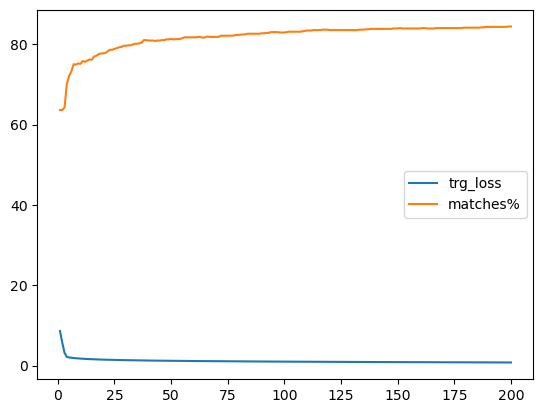

In [17]:
# df['matches%'] = df['matches%']/10
df[['trg_loss','matches%']][1:].plot();

In [14]:
type(w), len(w)

(numpy.ndarray, 785)